# Постановка задачи

Имеется выборка из подержанных автомобилей, выставленных на продажу в Соединённых Штатах. На этих данных нужно построить модель классификации, определяющую категорию цены подержанного автомобиля в зависимости от характеристик транспортного средства.

# Описание датасета

- `id`: идентификатор записи;
- `url`: URL записи о продаже;
- `region`: регион;
- `region_url`: URL региона;
- `price`: стоимость;
- `year`: год выпуска;
- `manufacturer`: производитель;
- `model`: модель;
- `fuel`: тип топлива;
- `odometer`: количество пройденных миль;
- `title_status`: статус;
- `transmission`: коробка передач;
- `image_url`: URL изображения;
- `description`: указанное описание;
- `state`: штат;
- `lat`: широта;
- `long`: долгота;
- `posting_date`: дата размещения объявления о продаже;
- `price_category`: категория цены.

###  Задачи:

Ниже представлены задачи по проекту построения модели. Выполните их и в отдельном файле соберите финальный ноутбук проекта. 

# 0. Подготовка

## 0.0. Импорт библиотек

In [1]:
import math
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

## 0.1. Загрузка данных

In [2]:
df_car_data = pd.read_csv('car_data.csv')
df_car_data.shape

(10000, 19)

# 1. Data Preparation

## 1.0. Проверка/удаление дубликатов и пропусков; приведение типов

In [3]:
df_car_data[df_car_data.duplicated()]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category


In [4]:
df_car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10000 non-null  int64  
 1   url             10000 non-null  object 
 2   region          10000 non-null  object 
 3   region_url      10000 non-null  object 
 4   price           10000 non-null  int64  
 5   year            9964 non-null   float64
 6   manufacturer    10000 non-null  object 
 7   model           9872 non-null   object 
 8   fuel            9937 non-null   object 
 9   odometer        9958 non-null   float64
 10  title_status    9834 non-null   object 
 11  transmission    9955 non-null   object 
 12  image_url       9998 non-null   object 
 13  description     9998 non-null   object 
 14  state           10000 non-null  object 
 15  lat             9902 non-null   float64
 16  long            9902 non-null   float64
 17  posting_date    9998 non-null   

In [5]:
cols_for_drop = ['id', 'price', 'image_url', 'region_url', 'url'] # удалить
cols_for_drop_nan = ['year', 'posting_date'] # удалить строки с пропусками
cols_for_other = ['model', 'fuel', 'title_status', 'transmission', 'description'] # заменить пропуски на "other"
cols_for_mean = ['lat', 'long', 'odometer'] # заменить пропуски на среднее арифметическое

df = df_car_data.copy()
df = df.drop(cols_for_drop, axis=1)
df = df.dropna(subset=cols_for_drop_nan)
df[cols_for_other] = df[cols_for_other].fillna('other')

for col in cols_for_mean:
    m = df[col].mean()
    df[[col]] = df[[col]].fillna(m)

df.year = df.year.astype('int')
df1 = df.copy()
df.shape

(9964, 14)

## 1.1 Удаление выбросов

In [6]:
num_cols = []
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        num_cols.append(col)

In [7]:
def visual(df, cols, shapiro=False):
    for col in cols:
        if shapiro:
            print(col, ' : ', sps.shapiro(df[col]))
        fig, ax = plt.subplots(2,1, figsize=(10,7), sharex=True)
        ax[0].hist(df[col])
        ax[1].boxplot(df[col], vert=False)
        plt.xlabel(col)
        ax[0].set_ylabel('Частота')
        fig.suptitle(f'Гистограмма и boxplot для "{col}"')
        plt.show()

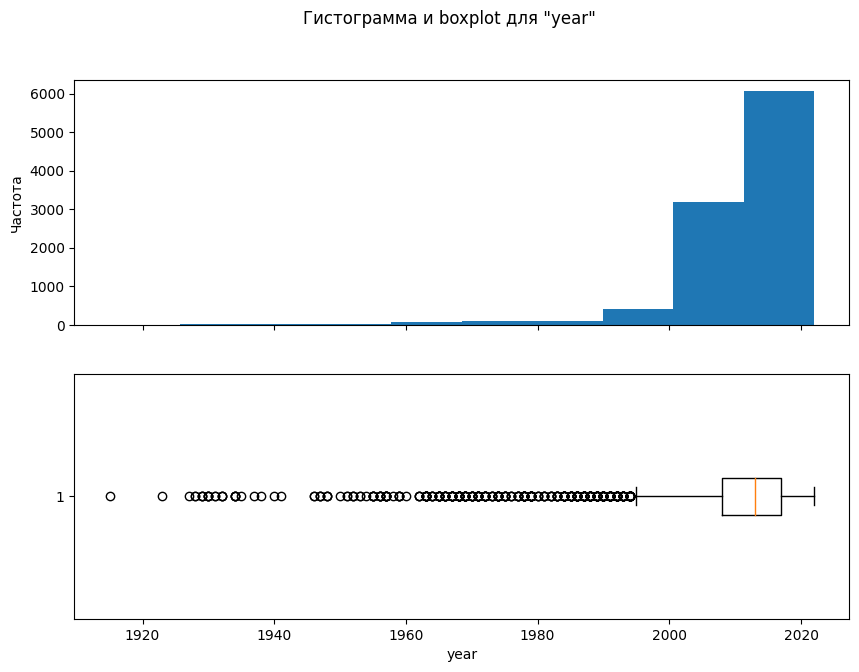

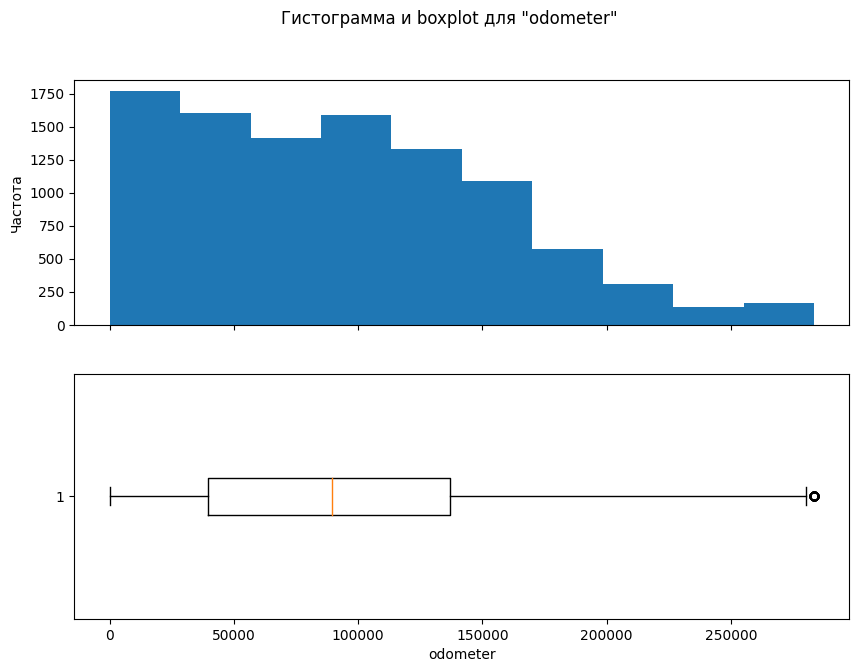

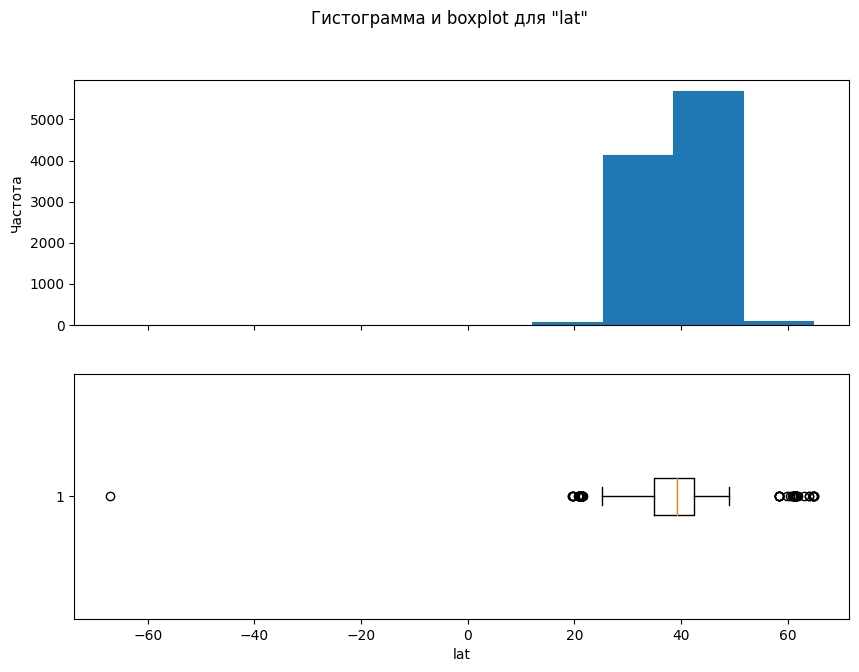

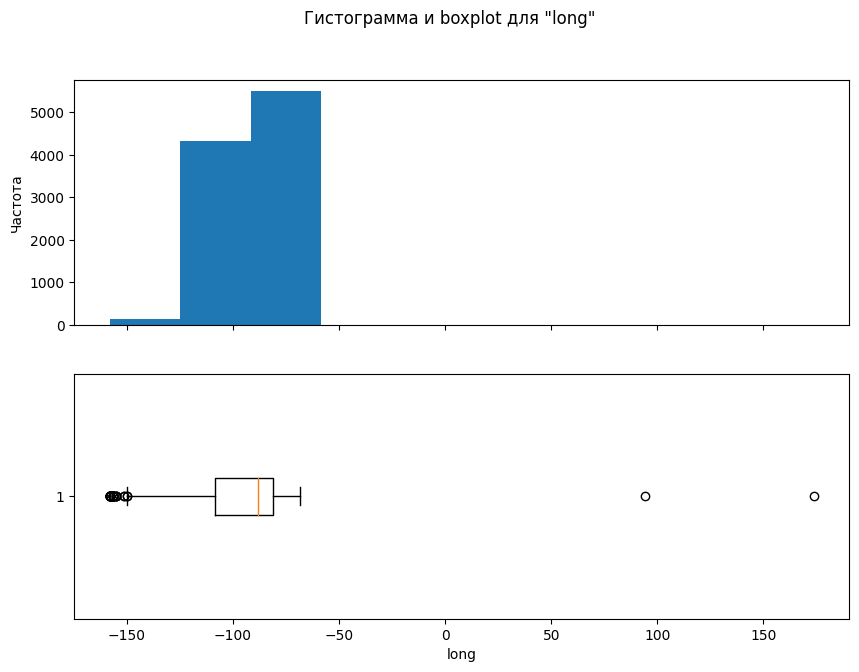

In [8]:
visual(df,num_cols)

Поскольку выборки не нормальны, заменим выбросы методом квантилей.

In [9]:
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    delta = q75 - q25
    return q25 - 1.5*delta, q75 + 1.5*delta

def anomal_replace(df, num_cols):
    for col in num_cols:
        a, b = calculate_outliers(df[col])
        out_less = df[col] < a
        out_grater = df[col] > b
        if df[col].dtype == 'int':
            df.loc[out_less, col] = int(a)
            df.loc[out_grater, col] = int(b)
        else:
            df.loc[out_less, col] = a
            df.loc[out_grater, col] = b

In [10]:
df = df1.copy()
anomal_replace(df, num_cols)
df2 = df.copy()

# 2. Feature engineering

## Новые фичи

In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9964 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   region          9964 non-null   object 
 1   year            9964 non-null   int64  
 2   manufacturer    9964 non-null   object 
 3   model           9964 non-null   object 
 4   fuel            9964 non-null   object 
 5   odometer        9964 non-null   float64
 6   title_status    9964 non-null   object 
 7   transmission    9964 non-null   object 
 8   description     9964 non-null   object 
 9   state           9964 non-null   object 
 10  lat             9964 non-null   float64
 11  long            9964 non-null   float64
 12  posting_date    9964 non-null   object 
 13  price_category  9964 non-null   object 
dtypes: float64(3), int64(1), object(10)
memory usage: 1.1+ MB


In [12]:
df = df2.copy()
# Длина описания. Важен скорее логарифм.
# df['description_len'] = df['description'].apply(lambda x: len(x))
df['description_len_log'] = df['description'].apply(lambda x: math.log(len(x)))
# Оъединим марку и модель, сократив модель до 1 слова.
df['model_short'] = df.apply(lambda x: x['manufacturer'].lower() + ' ' + x['model'].lower().split()[0], axis=1)
# Из даты объявления важны только год и месяц, причём вместе, а не потдельности,
# поскольку месяц -- это циклический параметр
def month(date):
    s = date.split('-')
    y = int(s[0])
    m = int(s[1])
    return m + 12*y    
df['posting_month'] = df['posting_date'].apply(month)
# Посчитаем возраст и сразу исключим отрицацельный возраст как выброс. 
df['age'] = df.apply(lambda x: max(0, x['posting_month'] // 12 - x['year']), axis=1)
# Посчитаем используемость автомобиля = средний пробег в год (делим на количество полных лет + пол года):
df['use'] = df.apply(lambda x: x['odometer'] / (x['age'] + 0.5), axis=1)
# Параметр date не указан в описании. Он отличается от posting_date на 0 и изредка на 1 месяц:
# print(df.apply(lambda x: month(x['date']) - x['posting_month'], axis=1).value_counts())
# Поэтому параметр date лишний.
# Удалим не нужные более параметры:
df = df.drop(['description', 'manufacturer', 'model', 'posting_date'], axis=1)
# Удалим выбросы в новых фичах.
num_cols_new = []
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]) and col not in num_cols:
        num_cols_new.append(col)

anomal_replace(df, num_cols_new)
df3 = df.copy()

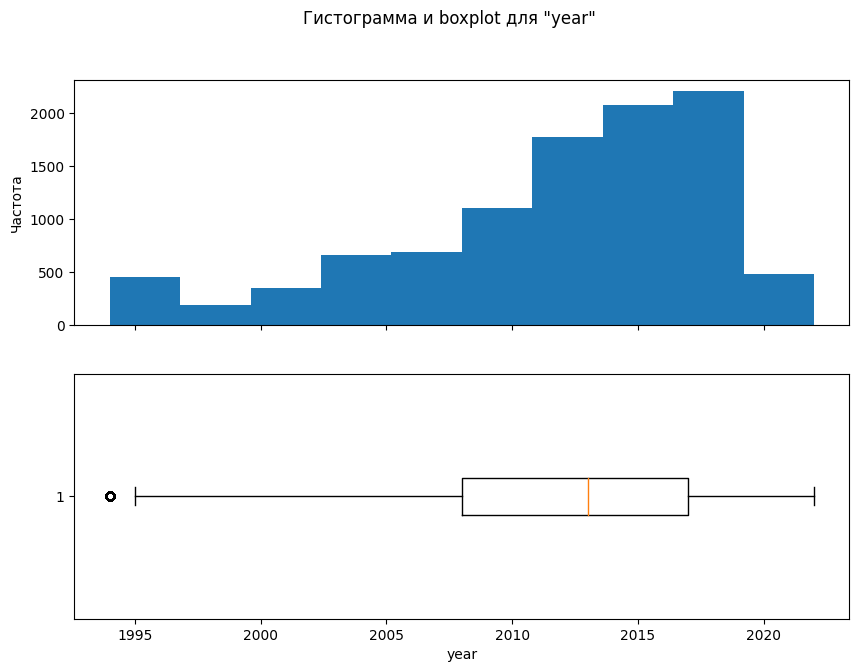

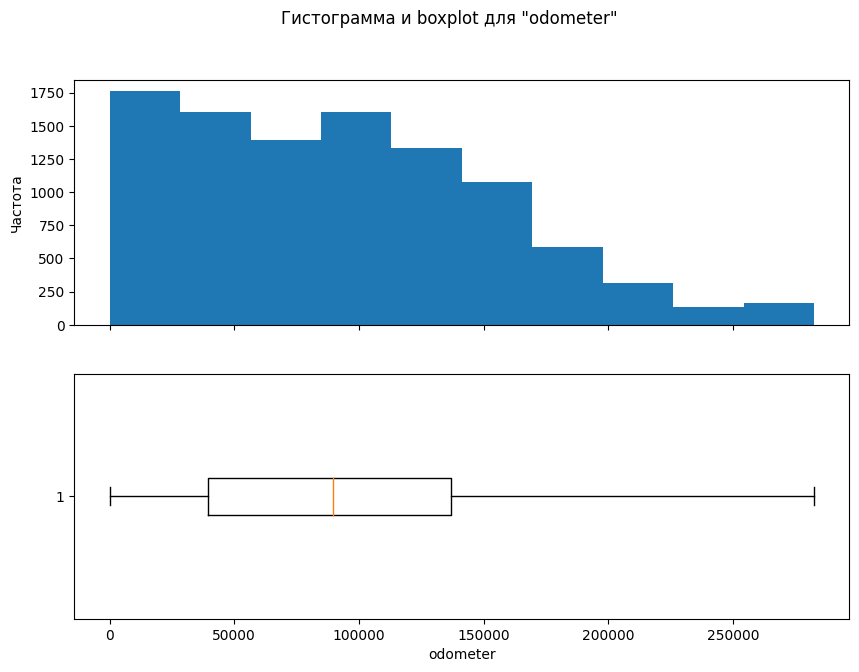

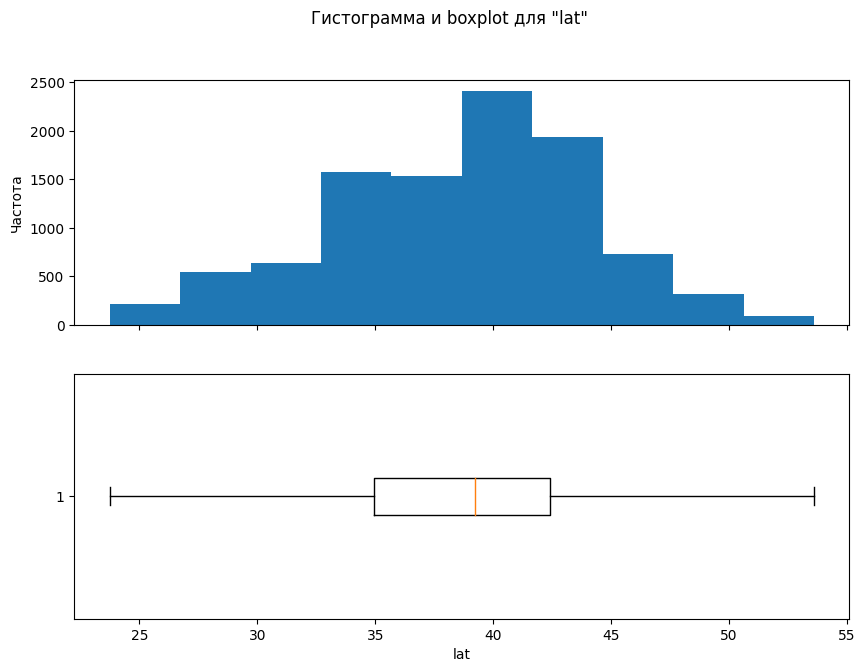

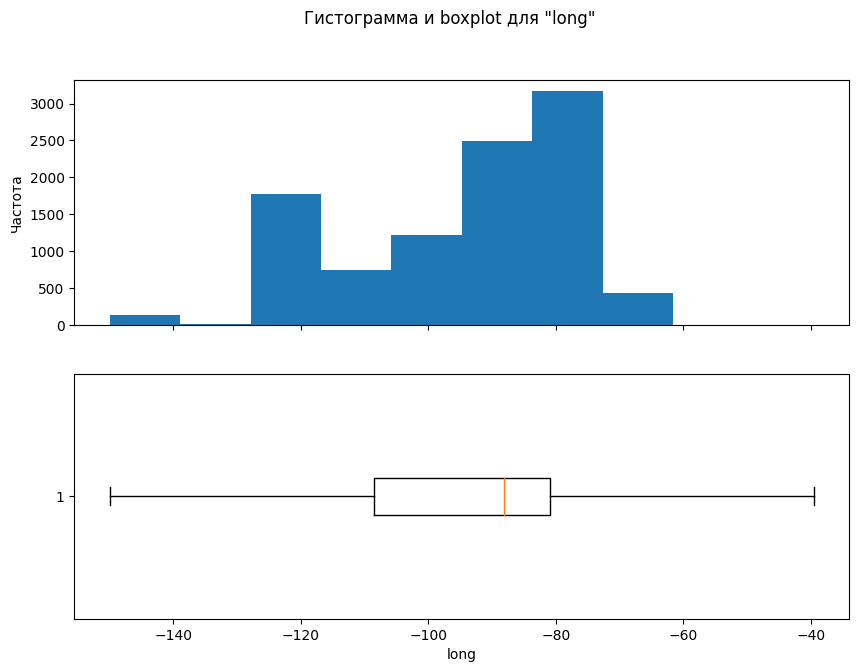

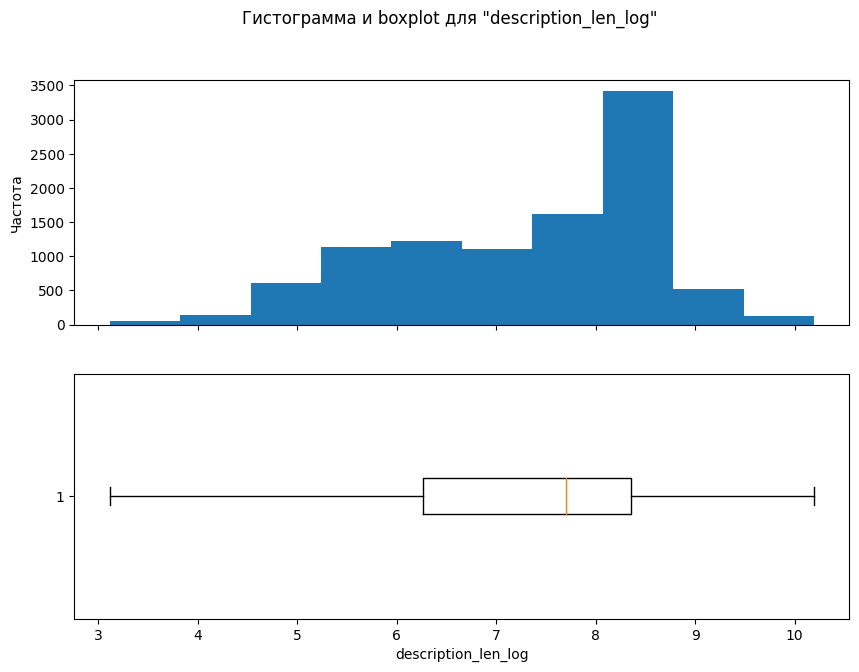

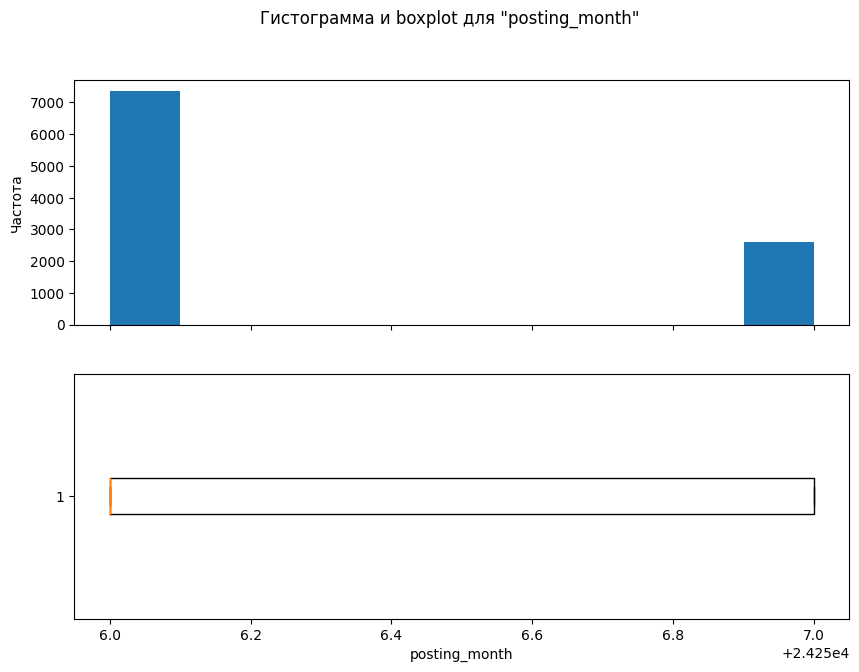

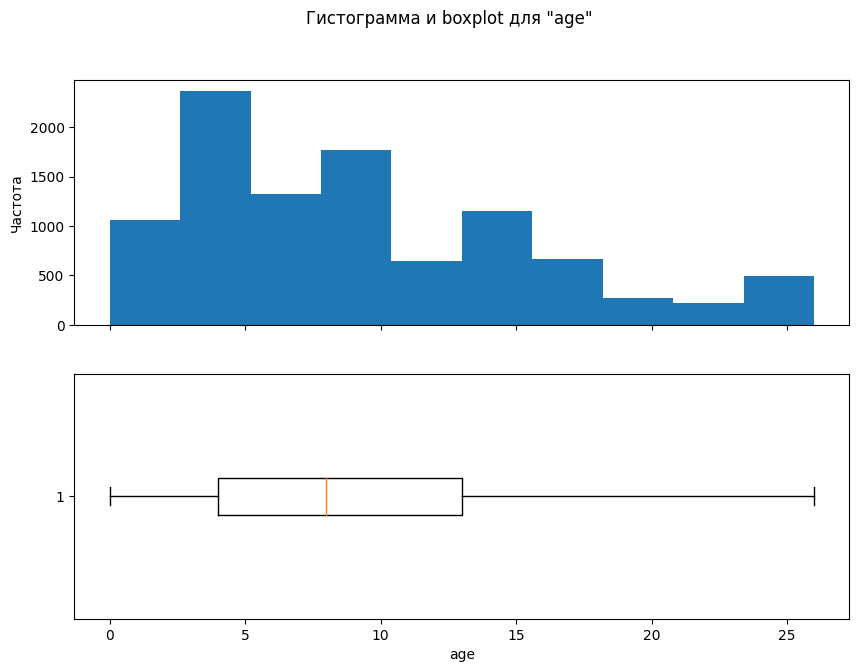

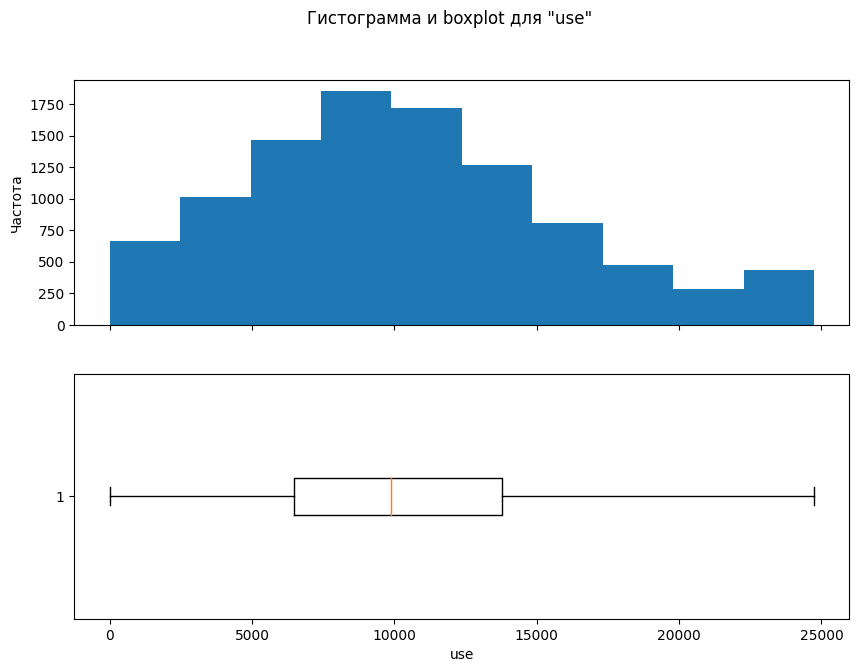

In [13]:
visual(df3, num_cols + num_cols_new)

##### Feature preparing

In [14]:
df = df3.copy()
# Сразу выделим целевую переменную:
y = df['price_category']
df = df.drop(['price_category'], axis=1)
ohe = OneHotEncoder(sparse=False)
stand_sc = StandardScaler()
num_cols_full = num_cols + num_cols_new
cat_cols = list(set(df.columns) - set(num_cols_full))
df_cat = pd.DataFrame(ohe.fit_transform(df[cat_cols]), columns=ohe.get_feature_names_out())
df_num = pd.DataFrame(stand_sc.fit_transform(df[num_cols_full]), columns=num_cols_full)
print(df.shape)
df = pd.concat([df_num,df_cat], axis=1)
df_prep = df.copy()

(9964, 14)


In [15]:
df_prep.isna().any()

year                       False
odometer                   False
lat                        False
long                       False
description_len_log        False
                           ...  
title_status_missing       False
title_status_other         False
title_status_parts only    False
title_status_rebuilt       False
title_status_salvage       False
Length: 1505, dtype: bool

# 3. Modelling

## 3.0. Разделение данных

In [16]:
X = df_prep.copy()
train_x, test_x, train_y, test_y = train_test_split(X, y, random_state=42, test_size=0.2)
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((7971, 1505), (1993, 1505), (7971,), (1993,))

## 3.1. Логистическая регрессия

In [17]:
logis = LogisticRegression()
param_grid = {'C': list(range(5,11)), 'solver': ['newton-cg', 'lbfgs']}
grid_search_logis = GridSearchCV(logis, param_grid, cv=4, scoring='accuracy', refit=False)
grid_search_logis.fit(train_x, train_y)
grid_search_logis.best_params_

{'C': 6, 'solver': 'newton-cg'}

In [18]:
cv_res = grid_search_logis.cv_results_
for m, p in zip(cv_res['mean_test_score'], cv_res['params']):
    print(m, p)

0.7691618833588242 {'C': 5, 'solver': 'newton-cg'}
0.7666532285690679 {'C': 5, 'solver': 'lbfgs'}
0.7711693487447029 {'C': 6, 'solver': 'newton-cg'}
0.7650223951500935 {'C': 6, 'solver': 'lbfgs'}
0.7705424054471777 {'C': 7, 'solver': 'newton-cg'}
0.7647708873627979 {'C': 7, 'solver': 'lbfgs'}
0.7710443505079021 {'C': 8, 'solver': 'newton-cg'}
0.7638932549062281 {'C': 8, 'solver': 'lbfgs'}
0.7697898971702162 {'C': 9, 'solver': 'newton-cg'}
0.7635171267105552 {'C': 9, 'solver': 'lbfgs'}
0.7697900231130241 {'C': 10, 'solver': 'newton-cg'}
0.7626385496829263 {'C': 10, 'solver': 'lbfgs'}


In [19]:
logis = LogisticRegression(max_iter=300, C=8, solver='newton-cg')
cv_logis = cross_val_score(logis, train_x, train_y, cv=4)

## 3.2. Случайный лес

In [20]:
forest = RandomForestClassifier()
param_grid = {'bootstrap': [False, True],
              'n_estimators': [400, 450, 500, 550], 'max_depth': [3000, 5000, 7000]}
grid_search = GridSearchCV(forest, param_grid, cv=5, scoring='accuracy', refit=False)
grid_search.fit(train_x, train_y)
grid_search.best_params_

{'bootstrap': False, 'max_depth': 7000, 'n_estimators': 550}

In [21]:
cv_res = grid_search.cv_results_
for m, p in zip(cv_res['mean_test_score'], cv_res['params']):
    print(m, p)

0.7498415295603026 {'bootstrap': False, 'max_depth': 3000, 'n_estimators': 400}
0.7485865884213135 {'bootstrap': False, 'max_depth': 3000, 'n_estimators': 450}
0.7517227219628466 {'bootstrap': False, 'max_depth': 3000, 'n_estimators': 500}
0.7524758597090185 {'bootstrap': False, 'max_depth': 3000, 'n_estimators': 550}
0.7508442710320441 {'bootstrap': False, 'max_depth': 5000, 'n_estimators': 400}
0.750217469114194 {'bootstrap': False, 'max_depth': 5000, 'n_estimators': 450}
0.751472174258485 {'bootstrap': False, 'max_depth': 5000, 'n_estimators': 500}
0.7482103342078249 {'bootstrap': False, 'max_depth': 5000, 'n_estimators': 550}
0.7500918412699662 {'bootstrap': False, 'max_depth': 7000, 'n_estimators': 400}
0.7503437262776163 {'bootstrap': False, 'max_depth': 7000, 'n_estimators': 450}
0.7499663707555371 {'bootstrap': False, 'max_depth': 7000, 'n_estimators': 500}
0.7536049370090818 {'bootstrap': False, 'max_depth': 7000, 'n_estimators': 550}
0.7428164393906617 {'bootstrap': True, 'ma

In [24]:
forest = RandomForestClassifier(bootstrap=False, max_depth=7000, n_estimators=550)
cv_forest = cross_val_score(forest, train_x, train_y, cv=5)

In [25]:
# Проверка эффективности новых фичей
forest.fit(train_x, train_y)
f_imp = list(zip(X.columns, forest.feature_importances_))
f_imp.sort(key = lambda x: x[1], reverse=True)
f_imp

[('year', 0.09788600469069886),
 ('age', 0.09536193480891857),
 ('odometer', 0.09174452709037816),
 ('description_len_log', 0.07915403606626502),
 ('use', 0.052712103596158216),
 ('long', 0.03971725465288113),
 ('lat', 0.03943575262792856),
 ('transmission_other', 0.014625915799131993),
 ('fuel_gas', 0.014144405742888468),
 ('fuel_diesel', 0.012722020560014645),
 ('transmission_automatic', 0.011230681980794664),
 ('model_short_chevrolet silverado', 0.009246199865564981),
 ('posting_month', 0.007931052525498842),
 ('model_short_jeep wrangler', 0.006775565782326019),
 ('fuel_other', 0.005298475616508408),
 ('model_short_gmc sierra', 0.004521185625862881),
 ('transmission_manual', 0.004220047851096942),
 ('model_short_ram 1500', 0.004179931040452712),
 ('title_status_clean', 0.004005722022074698),
 ('model_short_ford f-150', 0.003916470679797664),
 ('model_short_toyota tacoma', 0.003779017922889866),
 ('state_ca', 0.003769392148009285),
 ('model_short_kia soul', 0.0029725751594555016),
 (

Новые фичи эффективны

## 3.3. Нейронная сеть

In [26]:
mlp = MLPClassifier()
param_grid = {'activation': ['logistic', 'relu'], 'solver': ['sgd', 'adam']}
grid_search_mlp = GridSearchCV(mlp, param_grid, cv=4, scoring='accuracy', refit=False)
grid_search_mlp.fit(train_x, train_y)
grid_search_mlp.best_params_

{'activation': 'logistic', 'solver': 'adam'}

In [27]:
mlp = MLPClassifier(activation='logistic', solver='adam', max_iter=500)
cv_mlp = cross_val_score(mlp, train_x, train_y, cv=4)

## 3.4 Метод опорных векторов

In [42]:
svc = SVC()
param_grid = {'C': [1, 10, 15], 'kernel': ['linear', 'rbf']} 
grid_search_svc = GridSearchCV(svc, param_grid, cv=4, scoring='accuracy', refit=False)
grid_search_svc.fit(train_x, train_y)
grid_search_svc.best_params_

{'C': 10, 'kernel': 'linear'}

In [43]:
cv_res = grid_search_svc.cv_results_
for m, p in zip(cv_res['mean_test_score'], cv_res['params']):
    print(m, p)

0.7758110968711776 {'C': 1, 'kernel': 'linear'}
0.7406833178171793 {'C': 1, 'kernel': 'rbf'}
0.7790733304517619 {'C': 10, 'kernel': 'linear'}
0.7729256212003055 {'C': 10, 'kernel': 'rbf'}
0.7771914300453193 {'C': 15, 'kernel': 'linear'}
0.7714201008751514 {'C': 15, 'kernel': 'rbf'}


In [44]:
svc = SVC(C=10, kernel='linear')
cv_svc = cross_val_score(svc, train_x, train_y, cv=4)

## 3.5. Сравнение

In [45]:
print(f'mean = {cv_logis.mean():.5f}, std = {cv_logis.std():.5f} \u2014 Логистическая регрессия')
print(f'mean = {cv_forest.mean():.5f}, std = {cv_forest.std():.5f} \u2014 Случайный лес')
print(f'mean = {cv_mlp.mean():.5f}, std = {cv_mlp.std():.5f} \u2014 Нейронная сеть')
print(f'mean = {cv_svc.mean():.5f}, std = {cv_svc.std():.5f} \u2014 Метод опорных векторов')

mean = 0.77104, std = 0.00621 — Логистическая регрессия
mean = 0.75260, std = 0.01056 — Случайный лес
mean = 0.77142, std = 0.00374 — Нейронная сеть
mean = 0.77907, std = 0.00570 — Метод опорных векторов


В среднем лучший результат даёт Метод опорных векторов, но нейронная сеть и логистическая регрессия статистически не хуже. Причём Метод опорных векторов работает быстрее.

# 4. Evaluation

Посчитаем метрику accuracy на тестовой выборке:

In [46]:
models = [logis, forest, mlp, svc]
for model in models:
    model.fit(train_x, train_y)
    pred_train = model.predict(train_x)
    pred_test = model.predict(test_x)
    print('На тренеровочных данных:', accuracy_score(pred_train, train_y), '\tНа тестовых данных: ',  accuracy_score(pred_test, test_y), ' : ', model)

На тренеровочных данных: 0.8872161585748338 	На тестовых данных:  0.7877571500250878  :  LogisticRegression(C=8, max_iter=300, solver='newton-cg')
На тренеровочных данных: 0.9998745452264459 	На тестовых данных:  0.7686904164576016  :  RandomForestClassifier(bootstrap=False, max_depth=7000, n_estimators=550)
На тренеровочных данных: 0.9993727261322294 	На тестовых данных:  0.7827395885599598  :  MLPClassifier(activation='logistic', max_iter=500)
На тренеровочных данных: 0.8981307238740434 	На тестовых данных:  0.792272955343703  :  SVC(C=10, kernel='linear')


Случайный лес и нейронная сеть немного переобучены.

Остальные модели в порядке.

Случайный лес даёт слижком низкий результат на тестовой выборке и при кросс-валидации по сравнению с остальными.

Нейронную сеть можно бвло бы улучшить, но она слишком медленно обучается.

В результате выбераем метод опорных векторов.

In [48]:
# Сохраним лучшую модель:
svc.fit(X, y)
pred = svc.predict(X)
print('accuracy =', accuracy_score(pred, y))
with open('cvs_cars.pickle', 'wb') as file:
    pickle.dump(svc, file)

accuracy = 0.8941188277800081
